## LSTM测试

In [1]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from datetime import date
import requests
from requests.auth import HTTPBasicAuth
import pandas as pd
import numpy as np
import requests
from requests.auth import HTTPBasicAuth
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from datetime import datetime, timedelta
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import random
import os
import tensorflow as tf

/Users/loki/PycharmProjects/PythonProject5/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
today = date.today()

In [3]:
data = yf.download("CNYGBP=X", start="2015-01-01", end='2025-05-20')
all_test_df = data
all_test_df['ER'] = (all_test_df['High'] + all_test_df['Low']) / 2
all_test_df['inverse'] = 1/all_test_df['ER']
er_df = all_test_df[['inverse']].rename(columns={"Close": "CNY/GBP"})

# test average price


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
er_df = er_df.reset_index().rename(columns={'index': 'Date','inverse': 'ER'})
er_df['Date'] = pd.to_datetime(er_df['Date'])

In [5]:
df_weekday_aligned = er_df.copy()
df_weekday_aligned

Price,Date,ER
Ticker,,
0,2015-01-01,9.621861
1,2015-01-02,9.563429
2,2015-01-05,9.499834
3,2015-01-06,9.454924
4,2015-01-07,9.389671
...,...,...
2698,2025-05-13,9.529573
2699,2025-05-14,9.601536
2700,2025-05-15,9.577489


In [6]:
df_weekday_aligned['trade_war'] = 0
df_weekday_aligned.loc[(df_weekday_aligned['Date'] >= '2018-03-22') & (df_weekday_aligned['Date'] <= '2018-12-01'), 'trade_war'] = 1
df_weekday_aligned.loc[(df_weekday_aligned['Date'] >= '2025-02-01') , 'trade_war'] = 1

In [7]:
df_all = df_weekday_aligned

In [8]:
df_all['prev_change'] = df_all['ER'].pct_change().fillna(0)

# Create trend direction label (1 if next day up, 0 if down)
df_all['trend_up'] = (df_all['ER'].diff().shift(-1) > 0).astype(int)
df_all.dropna(inplace=True)  # drop last row if trend_up for next day is NaN

# Display the final feature set
display(df_all.tail(5))

Price,Date,ER,trade_war,prev_change,trend_up
Ticker,,,,,
2698,2025-05-13,9.529573,1,-0.004107,1
2699,2025-05-14,9.601536,1,0.007552,0
2700,2025-05-15,9.577489,1,-0.002504,1
2701,2025-05-16,9.580976,1,0.000364,1
2702,2025-05-19,9.622694,1,0.004354,0


In [9]:
lstm_df = df_all.drop(['prev_change'], axis=1)

lstm_df['Date'] = pd.to_datetime(lstm_df['Date'])  # 保证为 datetime 类型
lstm_df = lstm_df.set_index('Date')  # 设置为 index

In [10]:
np.random.seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

# 固定 TensorFlow 随机种子
tf.random.set_seed(42)

# 若用GPU，确保 TensorFlow 使用确定性算法
# 注意：这会牺牲一定速度
from tensorflow.keras import backend as K
os.environ['TF_DETERMINISTIC_OPS'] = '1'

## 使用全部数据进行训练，预测未来汇率

In [11]:
lstm_df

Price,ER,trade_war,trend_up
Ticker,,,
Date,,,
2015-01-01,9.621861,0,0
2015-01-02,9.563429,0,0
2015-01-05,9.499834,0,0
2015-01-06,9.454924,0,0
2015-01-07,9.389671,0,0
...,...,...,...
2025-05-13,9.529573,1,1
2025-05-14,9.601536,1,0


In [12]:
end_date = lstm_df.index.max()
start_date = end_date - pd.DateOffset(months=24)
last_n_months = lstm_df.loc[start_date:end_date]

In [13]:
train_df = lstm_df[int(len(lstm_df) * 0.25):]
    # Separate features (X) and target (y)
X_train = train_df # 注意：这里只取特征列
y_train = train_df['ER']

# Normalize features and target using Min-Max scaling (fit on training data only)
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))

# Prepare data for LSTM: create sequences of length `lookback` for each training example
lookback = 12  # use past 12 months to predict the next month
X_train_seq, y_train_seq = [], []
for i in range(lookback, len(X_train_scaled)):
    # sequence of `lookback` feature vectors
    X_train_seq.append(X_train_scaled[i-lookback:i])
    # target is the exchange rate at this time (one month ahead of last input month)
    y_train_seq.append(y_train_scaled[i])
X_train_seq = np.array(X_train_seq)
y_train_seq = np.array(y_train_seq)

train_len = len(X_train_scaled)
# Build the LSTM model
# 改进后的双层 LSTM 架构
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(lookback, X_train_seq.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dense(1))

# 别忘了这一步！！
model.compile(optimizer='adam', loss='mean_squared_error')

# 然后再训练
history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=16, verbose=1)

Epoch 1/50


/Users/loki/PycharmProjects/PythonProject5/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0472
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011
Epoch 9/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011
Epoch 10/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.2886e-04
Epoch 11/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.1918e-04
Epoch 12/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0177e-04
Epoch 13/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.4692e-04
Epoch 14/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6786e-04
Epoch 15/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

KeyboardInterrupt: 

In [15]:
test_loss_all = model.evaluate(X_train_seq, y_train_seq, verbose=0)
print(f"Test MSE Loss: {test_loss_all:.6f}")

Test MSE Loss: 0.000220


In [16]:
# 1. 准备输入
X_latest = X_train_scaled[-lookback:]
X_latest = X_latest.reshape(1, lookback, X_latest.shape[1])

# 2. 预测
y_pred_scaled = model.predict(X_latest)

# 3. 反归一化
y_pred = target_scaler.inverse_transform(y_pred_scaled)
print(f"Predicted next exchange rate: {y_pred[0][0]:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Predicted next exchange rate: 9.5984


2025-05-24 23:06:04.330977: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-24 23:06:04.331268: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

In [16]:
# Sigmoid 转换为概率（你可以根据需求微调 k）
def sigmoid(x, k=10):
    return 1 / (1 + np.exp(-k * x))

In [17]:
pred_change = y_pred[0][0] - er_df.iloc[-1, -1]

up_probabilities = sigmoid(pred_change)

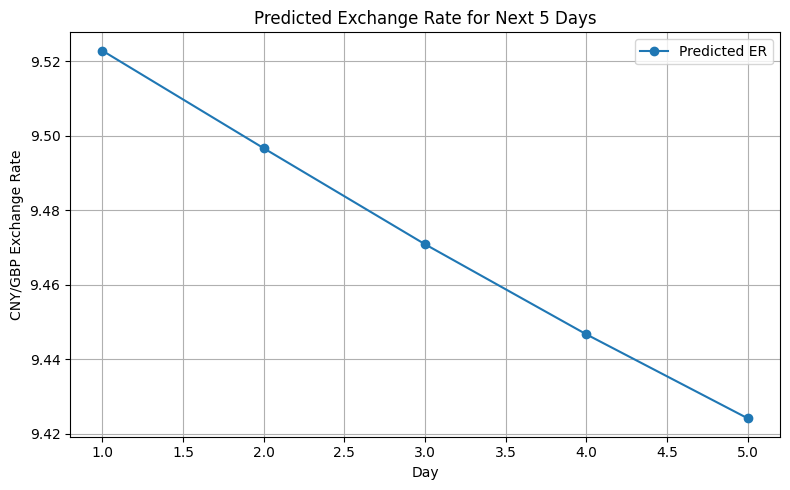

In [26]:
# 创建横轴标签
days = np.arange(1, len(future_preds) + 1)

# 画图
plt.figure(figsize=(8, 5))
plt.plot(days, future_preds, marker='o', linestyle='-', label='Predicted ER')
plt.title('Predicted Exchange Rate for Next 5 Days')
plt.xlabel('Day')
plt.ylabel('CNY/GBP Exchange Rate')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from datetime import datetime
lookback = 12
features = lstm_df.drop(columns=["trend_up"])
labels = lstm_df["trend_up"]

# 标准化特征
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# 构建序列样本
X, y = [], []
for i in range(lookback, len(features_scaled)):
    X.append(features_scaled[i-lookback:i])
    y.append(labels.iloc[i])
X = np.array(X)
y = np.array(y)

# Step 2: 构建 LSTM 分类模型
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(lookback, X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Step 3: 模型训练
model.fit(X, y, epochs=30, batch_size=16, validation_split=0.1, verbose=1)

# Step 4: 预测明日趋势概率
X_latest = features_scaled[-lookback:]
X_latest = X_latest.reshape(1, lookback, X.shape[2])

up_prob = model.predict(X_latest)[0][0]
pred_trend = 1 if up_prob > 0.5 else 0

# Step 5: 保存结果
output_df = pd.DataFrame({
    "date": [datetime.today().strftime('%Y-%m-%d')],
    "up_prob": [up_prob],
    "predicted_trend": [pred_trend]
})
#output_df.to_csv(f"output/trend_prediction_{output_df['date'][0]}.csv", index=False)

print("明日上涨概率:", round(up_prob, 4), "→ 预测为:", "上涨" if pred_trend else "下跌")

Epoch 1/30


/Users/loki/PycharmProjects/PythonProject5/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4944 - loss: 0.6946 - val_accuracy: 0.5093 - val_loss: 0.6929
Epoch 2/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5059 - loss: 0.6932 - val_accuracy: 0.5056 - val_loss: 0.6925
Epoch 3/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5155 - loss: 0.6930 - val_accuracy: 0.5093 - val_loss: 0.6924
Epoch 4/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5196 - loss: 0.6928 - val_accuracy: 0.5093 - val_loss: 0.6922
Epoch 5/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5286 - loss: 0.6927 - val_accuracy: 0.5093 - val_loss: 0.6921
Epoch 6/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5149 - loss: 0.6926 - val_accuracy: 0.5130 - val_loss: 0.6920
Epoch 7/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5012 - loss: 0.6925 - val_accuracy: 0.5167 - val_loss: 0.6920
Epoch 8/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5230 - loss: 0.6923 - val_accuracy: 0.5242 - val_

2025-05-24 22:15:21.287763: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-24 22:15:21.287983: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),